# Image Classification with Caffe

This tutorial demonstrates the steps required to prepare and deploy a trained Caffe model for FPGA acceleration using Xilinx MLSuite:  
1. **Quantize the model** - The quantizer will generate scaling parameters for quantizing floats INT8. This is required, because FPGAs will take advantage of Fixed Point Precision, to achieve more parallelization at lower power. 
2. **Compile the Model** - In this step, the network Graph (prototxt) and the Weights (caffemodel) are compiled, the compiler 
3. **Subgraph Cutting** - In this step, the original graph is cut, and a custom FPGA accelerated python layer is inserted to be used for Inference. 
4. **Classification** - In this step, the caffe model and the prototxt from the previous step are run on the FPGA to perform inference on an input image.
  
For command line versions see: examples/caffe/  
  
## Prerequisite Files
1. **Model files** - This notebook requires that model files are located in  
  `/opt/models/caffe`
2. **Image files** - This notebook requires ilsvrc2012 image files are downloaded in  
  `HOME/CK-TOOLS/dataset-imagenet-ilsvrc2012-val-min/`
  
## Setup (Before Running Notebook)
```
cd /opt/ml-suite/examples/caffe
python -m ck pull repo:ck-env
python -m ck install package:imagenet-2012-val-min
python -m ck install package:imagenet-2012-aux
head -n 500 $HOME/CK-TOOLS/dataset-imagenet-ilsvrc2012-aux/val.txt > $HOME/CK-TOOLS/dataset-imagenet-ilsvrc2012-val-min/val_map.txt
python resize.py $HOME/CK-TOOLS/dataset-imagenet-ilsvrc2012-val-min 256 256
source $MLSUITE_ROOT/overlaybins/setup.sh
```

### Step 1. Import required packages

In [ ]:
from __future__ import print_function

# Bring in ml-suite Quantizer, Compiler, SubGraph Cutter
from decent import CaffeFrontend as xfdnnQuantizer
from xfdnn.tools.compile.bin.xfdnn_compiler_caffe  import CaffeFrontend as xfdnnCompiler
from xfdnn_subgraph import CaffeCutter as xfdnnCutter

# Environment Variables ("source overlaybins/setup.sh")
import os
HOME = os.getenv("HOME","/home/mluser")
MLSUITE_ROOT = os.getenv("MLSUITE_ROOT","../")
MLSUITE_PLATFORM = os.getenv("MLSUITE_PLATFORM","alveo-u200")
print("Running w/ MLSUITE_ROOT: %s" % MLSUITE_ROOT)
print("Running w/ MLSUITE_PLATFORM: %s" % MLSUITE_PLATFORM)

from IPython.display import Image as display
from ipywidgets import interact

### Step 2. Choose a model
Choose a model using the drop down, or select custom, and enter your own.

In [2]:
@interact(MODEL=["bvlc_googlenet","inception_v2","inception_v3","inception_v4",\
                    "resnet50_v1","resnet50_v2","squeezenet","vgg16","custom"])
def selectModel(MODEL):
    global prototxt
    global caffemodel
    model_root = "/opt/models/caffe/"
    if MODEL == "custom":
        prototxt = None
        caffemodel = None
    else:
        prototxt = model_root + MODEL + "/" + MODEL + "_train_val.prototxt"
        caffemodel = model_root + MODEL + "/" + MODEL + ".caffemodel"

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnTU9ERUwnLCBvcHRpb25zPSgnYnZsY19nb29nbGVuZXQnLCAnaW5jZXB0aW9uX3YyJywgJ2luY2VwdGlvbl92MyfigKY=


In [3]:
if not prototxt:
    @interact(PROTOTXT="Provide the path to your prototxt")
    def selectPrototxt(PROTOTXT):
        global prototxt
        prototxt = PROTOTXT
    @interact(CAFFEMODEL="Provide the path to your caffemodel")
    def selectCaffemodel(CAFFEMODEL):
        global caffemodel
        caffemodel = CAFFEMODEL

In [4]:
print("Running with prototxt:   %s"%prototxt)
print("Running with caffemodel: %s"%caffemodel)

Running with prototxt:   /opt/models/caffe/bvlc_googlenet/bvlc_googlenet_train_val.prototxt
Running with caffemodel: /opt/models/caffe/bvlc_googlenet/bvlc_googlenet.caffemodel


### Step 3. Run the Quantizer

Here, we will quantize the model. The inputs are model prototxt, model weights, number of test iterations and calibration iterations. The output is quantized prototxt, weights, and quantize_info.txt and will be generated in the quantize_results/ directory.

The Quantizer will generate a json file holding scaling parameters for quantizing floats to INT8
This is required, because FPGAs will take advantage of Fixed Point Precision, to achieve accelerated inference

In [5]:
def Quantize(prototxt,caffemodel,calib_iter=1):
    
    quantizer = xfdnnQuantizer(
        model=prototxt,
        weights=caffemodel,
        calib_iter=calib_iter,
    )
    
    quantizer.quantize()

In [6]:
Quantize(prototxt,caffemodel)

### Step 4: Run the Compiler

The compiler takes in the quantizer outputs from the previous step (prototxt, weights, quantize_info) and outputs a compiler.json and quantizer.json.

* A Network Graph (prototxt) and a Weights Blob (caffemodel) are compiled
* The network is optimized
* FPGA Instructions are generated

In [7]:
# Some standard compiler arguments - PLEASE DONT TOUCH
def Getopts():
    return {
            "bytesperpixels":1,
            "dsp":96,
            "memory":9,
            "ddr":256,
            "cpulayermustgo":True,
            "mixmemorystrategy":True,
            "pipelineconvmaxpool":True,
            "usedeephi":True,
    }

In [8]:
def Compile(prototxt="quantize_results/deploy.prototxt",\
            caffemodel="quantize_results/deploy.caffemodel",\
            quantize_info="quantize_results/quantize_info.txt"):
    
    compiler = xfdnnCompiler(
        networkfile=prototxt,
        weights=caffemodel,
        quant_cfgfile=quantize_info,
        generatefile="work/compiler",
        quantz="work/quantizer",
        **Getopts()
    )
    
    compiler.compile()

In [ ]:
Compile()

### Step 4: Run the Subgraph Cutter

The subgraph cutter creates a custom python layer to be accelerated on the FPGA. The inputs are compiler.json, quantizer.json and model weights from the compiler step, as well as the FPGA xclbin. This outputs a cut prototxt file with FPGA references, to be used for inference. 

In [10]:
def Cut(prototxt):
    
    cutter = xfdnnCutter(
        inproto="quantize_results/deploy.prototxt",
        trainproto=prototxt,
        outproto="xfdnn_auto_cut_deploy.prototxt",
        outtrainproto="xfdnn_auto_cut_train_val.prototxt",
        cutAfter="data",
        xclbin=MLSUITE_ROOT+"/overlaybins/"+MLSUITE_PLATFORM+"/overlay_4.xclbin",
        netcfg="work/compiler.json",
        quantizecfg="work/quantizer.json",
        weights="work/deploy.caffemodel_data.h5",
        profile=True
    )
    
    cutter.cut()

In [ ]:
Cut(prototxt)

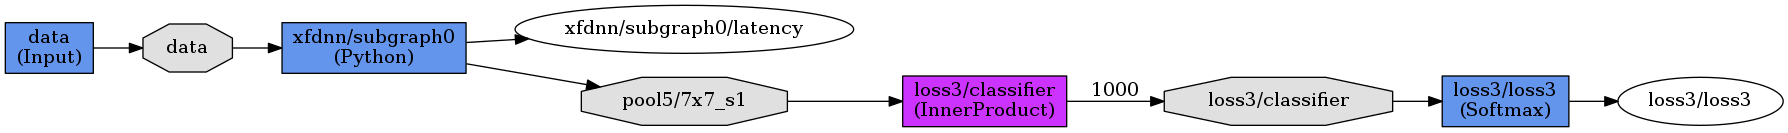

In [12]:
# Lets visualize the new graph with the FPGA subgraph
from google.protobuf import text_format
from caffe.proto import caffe_pb2
from caffe.draw import draw_net_to_file
net = caffe_pb2.NetParameter()
text_format.Merge(open("xfdnn_auto_cut_deploy.prototxt").read(), net)
draw_net_to_file(net,"xfdnn_auto_cut_deploy.png")
display("xfdnn_auto_cut_deploy.png")

### Step 5: Inference 

The inputs are the FPGA prototxt file, caffemodel weights, a test image, and the labels


In [13]:
def Classify(prototxt,caffemodel,image,labels):
    
    import numpy as np
    from caffe import Classifier,io
    classifier = Classifier(prototxt,caffemodel,
        mean=np.array([104,117,123]),
        raw_scale=255, channel_swap=[2,1,0])

    predictions = classifier.predict([io.load_image(image)]).flatten()
    labels = np.loadtxt(labels, str, delimiter='\t')
    top_k = predictions.argsort()[-1:-6:-1]
    for l,p in zip(labels[top_k],predictions[top_k]):
        print (l," : ",p)

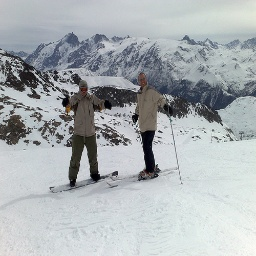

In [14]:
# Choose image to run, display it for reference
image = HOME+"/CK-TOOLS/dataset-imagenet-ilsvrc2012-val-min/ILSVRC2012_val_00000002.JPEG"
display(filename=image) 

In [15]:
Classify("xfdnn_auto_cut_deploy.prototxt",caffemodel,image,HOME+"/CK-TOOLS/dataset-imagenet-ilsvrc2012-aux/synset_words.txt") 

n04228054 ski  :  0.99189436
n09193705 alp  :  0.004577892
n04208210 shovel  :  0.0031982088
n04229816 ski mask  :  0.0002536632
n03218198 dogsled, dog sled, dog sleigh  :  3.3740147e-05


# Conclusion
This notebook demonstrates how to target Xilinx FPGAs for inference using Caffe.  
The custom Python layer is defined in /opt/ml-suite/xfdnn/rt/scripts/framework/caffe/CaffeXFDNN.py  
When the time comes to take your application to production please look at examples in /opt/ml-suite/examples/deployment_modes/  
Highest performance is acheived by creating multiprocess pipelines.